# Visualizing Important Regions in Images Using Grad-CAM with InceptionV3

The notebook demonstrates how to use Grad-CAM (Gradient-weighted Class Activation Mapping) to visualize which parts of an image are most important for a particular prediction made by a pre-trained InceptionV3 model.

- Import Necessary Libraries: We begin by importing several libraries needed for this task. These libraries include numpy for numerical operations, TensorFlow for deep learning, and Keras functions from TensorFlow for working with the InceptionV3 model. We also import functions for image preprocessing and displaying images using Matplotlib and OpenCV.

- Load the Pre-trained Model: We then load the InceptionV3 model, which has already been trained on the ImageNet dataset. This model can classify images into one of 1,000 different categories.

- Image Preprocessing Function: The preprocess_image function takes the path of an image as input, loads the image, and resizes it to 299x299 pixels to match the input size expected by InceptionV3. It then converts the image to a numpy array, adds an extra dimension to fit the model's input shape, and applies model-specific preprocessing.

- Compute Grad-CAM Heatmap: The get_gradcam_heatmap function calculates the Grad-CAM heatmap for the specified class index. It creates a model that outputs both the final convolutional layer's output and the model's predictions. Using TensorFlow's gradient tape, it computes the gradient of the class score concerning the feature map, averages these gradients, and creates a heatmap highlighting the important regions of the image for that class.

- Superimpose Heatmap on Original Image: The superimpose_heatmap function takes the path of the original image and the computed heatmap, resizes the heatmap to match the size of the original image, and applies a color map to it. It then overlays the heatmap onto the original image, creating a superimposed image where important regions are highlighted.

- Process and Display the Image: Then, we set the path to the test image and the class index for "tabby cat" (class index 281). We preprocess the image, compute the Grad-CAM heatmap, and superimpose the heatmap onto the original image.

- Display the Results: Finally, we create a side-by-side display of the original image and the superimposed Grad-CAM heatmap using Matplotlib. This allows for easy visualization of which parts of the image are most important for the model's prediction of the specified class.


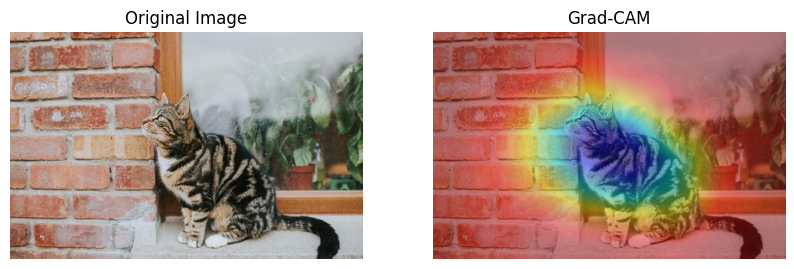

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import cv2

# Load the InceptionV3 model pre-trained on ImageNet
model = InceptionV3(weights='imagenet')

# Function to load and preprocess the image
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(299, 299))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img

# Function to compute the Grad-CAM heatmap
def get_gradcam_heatmap(model, img_array, class_index, last_conv_layer_name="mixed10"):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_layer_output, predictions = grad_model(img_array)
        loss = predictions[:, class_index]

    grads = tape.gradient(loss, conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_layer_output = conv_layer_output[0]
    # The matrix multiplication ('@') between conv_layer_output and pooled_grads[..., tf.newaxis]
    # results in a weighted sum of the feature maps, where the weights are the pooled gradients.
    heatmap = conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Function to superimpose the heatmap on the original image
def superimpose_heatmap(img_path, heatmap, alpha=0.4):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR (OpenCV) to RGB (Matplotlib)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(heatmap, alpha, img, 1 - alpha, 0)
    return superimposed_img

# Path to the test image
image_path = '/content/tabby.jpg'
class_index = 281 # Tabby cat

# Preprocess the image
img_array = preprocess_image(image_path)

# Get the Grad-CAM heatmap
heatmap = get_gradcam_heatmap(model, img_array, class_index)

# Superimpose the heatmap on the original image
superimposed_img = superimpose_heatmap(image_path, heatmap)

# Display the original image and the Grad-CAM result
plt.figure(figsize=(10, 5))

# Original image
plt.subplot(1, 2, 1)
original_img = load_img(image_path)
plt.imshow(original_img)
plt.title('Original Image')
plt.axis('off')

# Grad-CAM heatmap superimposed
plt.subplot(1, 2, 2)
plt.imshow(superimposed_img)
plt.title('Grad-CAM')
plt.axis('off')

plt.show()